In [ ]:
!pip install sktime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.7/20.7 MB 68.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 kB 19.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime as dt

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.layers import GRU, Bidirectional
from keras.optimizers import SGD
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sktime.param_est.stationarity import StationarityADF
from sktime.utils.plotting import plot_correlations
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
datos_2 = pd.read_excel("registros_autos_entrenamiento.xlsx")

datos_3 = pd.read_excel("registros_autos_entrenamiento.xlsx")
datos_3.index = pd.to_datetime(datos_3['Fecha'], format='%Y-%m-%d')

del datos_3["Fecha"]

In [ ]:
grafica_x = datos_2["Fecha"].loc[len(datos_2)-300:len(datos_2)]
grafica_y = datos_2['Unidades'].loc[len(datos_2)-300:len(datos_2)]

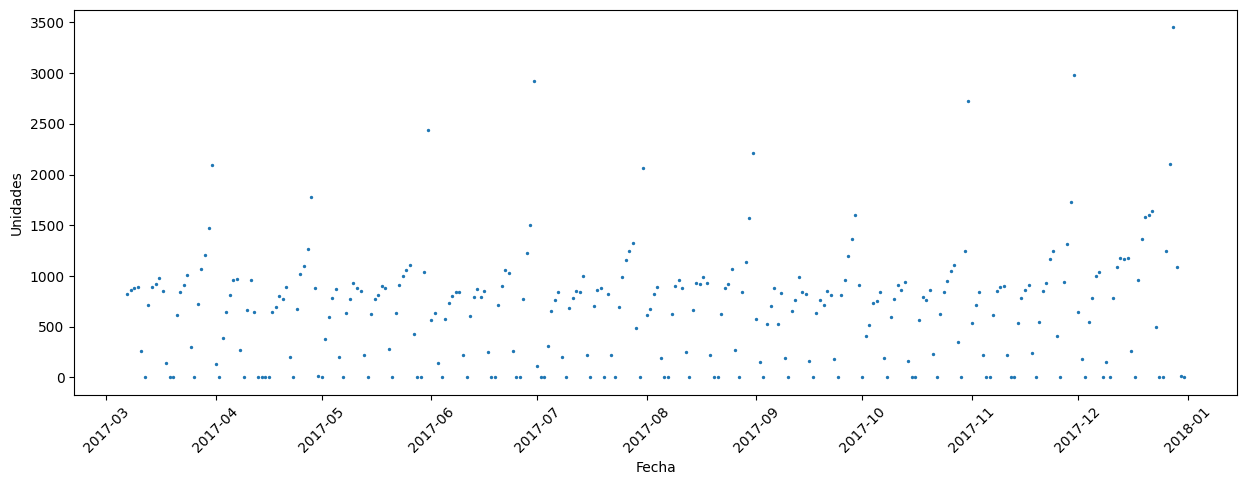

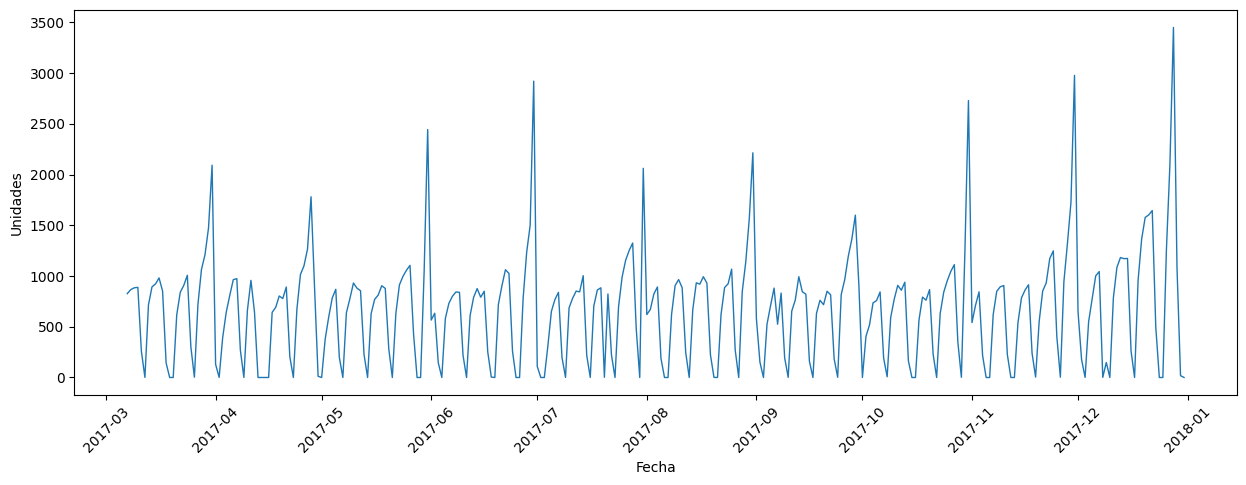

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.ylabel('Unidades')
plt.xlabel('Fecha')
plt.xticks(rotation=45)

fig, bx = plt.subplots(figsize=(15, 5))
plt.ylabel('Unidades')
plt.xlabel('Fecha')
plt.xticks(rotation=45)

ax.scatter(grafica_x, grafica_y, s=2)
bx.plot(grafica_x, grafica_y, linewidth=1.0)

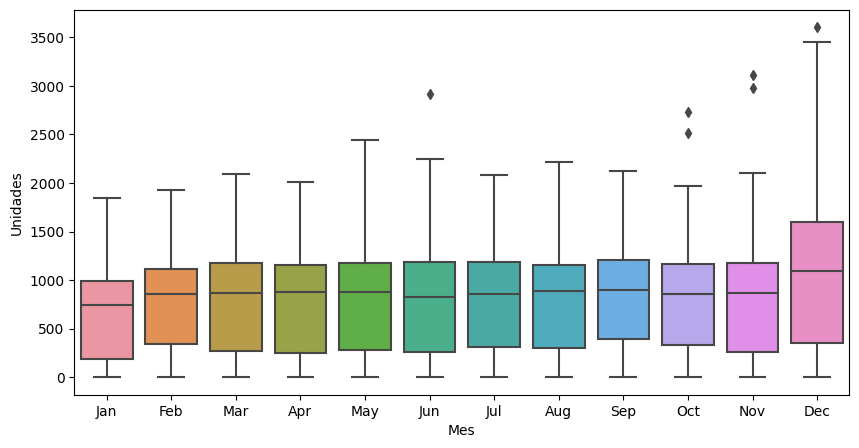

In [ ]:
datos_2["Mes"] = datos_2["Fecha"].dt.strftime('%b')

fig, ax = plt.subplots()
fig.set_size_inches((10,5))
sns.boxplot(x="Mes", y="Unidades", data = datos_2,ax=ax)

plt.show()

In [ ]:
# Analizamos si la serie es estacional usando ADF
sty_est = StationarityADF()
sty_est.fit(datos_3)
StationarityADF(...)
sty_est.get_fitted_params()["stationary"]

True

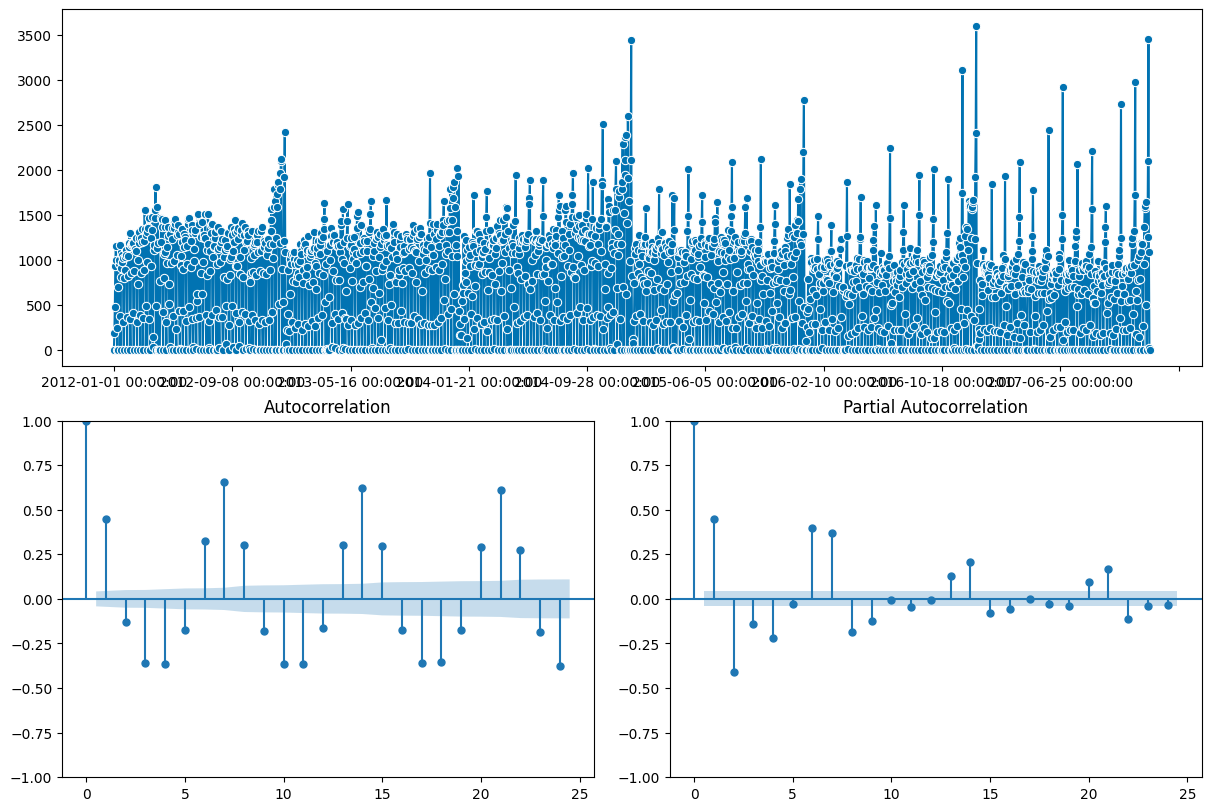

In [ ]:
fig, ax = plot_correlations(datos_3)

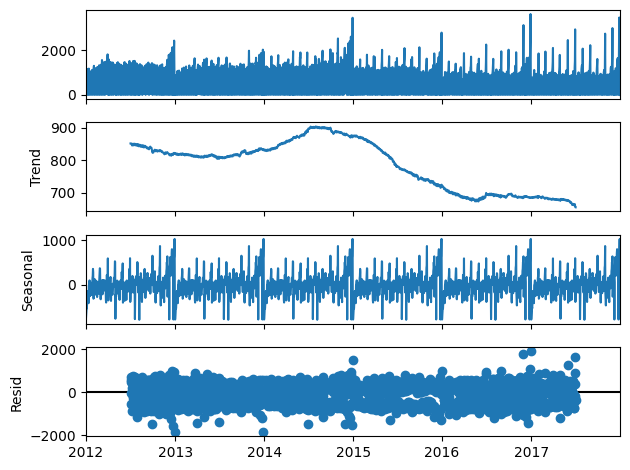

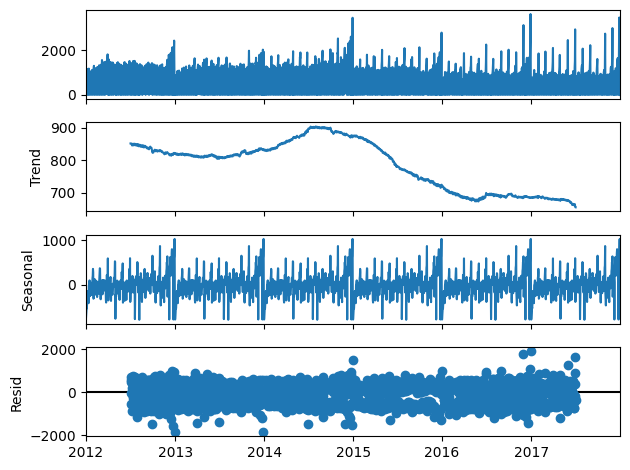

In [ ]:
results = seasonal_decompose(datos_3["Unidades"], period=365, model= "additive")
results.plot()

In [ ]:
train = datos_3.iloc[:len(datos_3)-365]
test = datos_3.iloc[len(datos_3)-365:]

In [ ]:
scaler = MinMaxScaler()

scaled_train = scaler.fit_transform(train)
scaled_test = scaler.fit_transform(test)

In [ ]:
scaled_train

array([[0.        ],
       [0.05217874],
       [0.13377741],
       ...,
       [1.        ],
       [0.26783236],
       [0.01276714]])

In [ ]:
n_input = 60
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=3)

In [ ]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.00000000e+00 5.21787399e-02 1.33777408e-01 2.57285595e-01
 3.21676381e-01 2.76436303e-01 6.74437968e-02 0.00000000e+00
 0.00000000e+00 1.93449903e-01 2.65334444e-01 2.77824036e-01
 3.24729392e-01 1.03247294e-01 2.77546489e-04 2.23424924e-01
 2.53399944e-01 2.91146267e-01 2.71718013e-01 2.82542326e-01
 8.65945046e-02 0.00000000e+00 2.22592284e-01 2.47849015e-01
 2.85872884e-01 3.07521510e-01 2.91146267e-01 1.02414654e-01
 5.55092978e-04 2.28420760e-01 2.90313628e-01 3.16958090e-01
 3.28892590e-01 3.59422703e-01 9.54759922e-02 0.00000000e+00
 2.36747155e-01 3.24729392e-01 3.26672218e-01 3.28059950e-01
 3.30557868e-01 1.14071607e-01 2.77546489e-04 2.44518457e-01
 3.10852068e-01 3.12517347e-01 3.04746045e-01 3.44990286e-01
 8.57618651e-02 0.00000000e+00 2.03441576e-01 2.75881210e-01
 3.29170136e-01 3.46100472e-01 3.64973633e-01 1.07132945e-01
 0.00000000e+00 2.37302248e-01 3.43880100e-01 3.33333333e-01
 5.21787399e-02 1.33777408e-01 2.57285595e-01 3.21676381e-01
 2.764

In [ ]:
# initializing the RNN
regressor = Sequential()

# adding RNN layers and dropout regularization
regressor.add(SimpleRNN(units = 50,
						activation = "tanh",
						return_sequences = True,
						input_shape = (n_input, n_features)))
regressor.add(Dropout(0.2))

regressor.add(SimpleRNN(units = 50,
						activation = "tanh",
						return_sequences = True))

regressor.add(SimpleRNN(units = 50,
						activation = "tanh",
						return_sequences = True))

regressor.add( SimpleRNN(units = 50))

# adding the output layer
regressor.add(Dense(units = 1,activation='sigmoid'))

# compiling RNN
regressor.compile(optimizer = SGD(learning_rate=0.01,
								weight_decay=1e-6,
								momentum=0.9,
								nesterov=True),
				loss = "mean_squared_error")

# fitting the model
regressor.fit(generator, epochs = 10)
regressor.summary()

In [ ]:
regressor_2 = Sequential()
regressor_2.add(LSTM(50, activation='relu', input_shape=(n_input, n_features)))
regressor_2.add(Dense(1))
regressor_2.compile(optimizer='adam', loss='mse')

regressor_2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 50)                10400     
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
regressor_2.fit(generator,epochs=20)

Epoch 1/20
589/589 [==============================] - 61s 100ms/step - loss: 0.0248
Epoch 2/20
589/589 [==============================] - 56s 95ms/step - loss: 0.0209
Epoch 3/20
589/589 [==============================] - 56s 94ms/step - loss: 0.0136
Epoch 4/20
589/589 [==============================] - 56s 95ms/step - loss: 0.0120
Epoch 5/20
589/589 [==============================] - 56s 95ms/step - loss: 0.0111
Epoch 6/20
589/589 [==============================] - 56s 94ms/step - loss: 0.0104
Epoch 7/20
589/589 [==============================] - 56s 95ms/step - loss: 0.0099
Epoch 8/20
589/589 [==============================] - 55s 94ms/step - loss: 0.0096
Epoch 9/20
589/589 [==============================] - 56s 95ms/step - loss: 0.0092
Epoch 10/20
589/589 [==============================] - 56s 95ms/step - loss: 0.0092
Epoch 11/20
589/589 [==============================] - 56s 94ms/step - loss: 0.0089
Epoch 12/20
589/589 [==============================] - 56s 95ms/step - loss: 0.0091


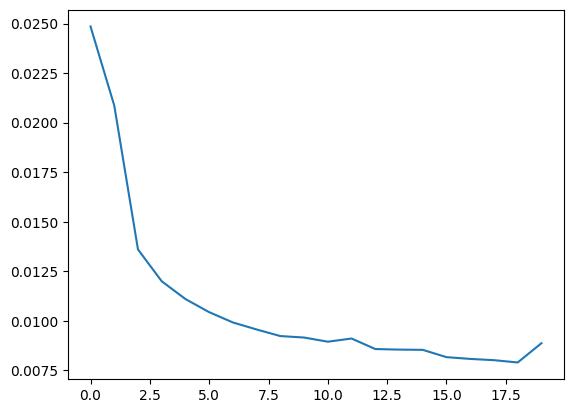

In [ ]:
loss_per_epoch = regressor_2.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
last_train_batch = scaled_train[-30:]

In [ ]:
last_train_batch = last_train_batch.reshape((1, 30, n_features))

In [ ]:
y_pred = regressor_2.predict(last_train_batch)

1/1 [==============================] - 0s 189ms/step


In [ ]:
scaled_test[0]

array([0.])

In [ ]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):

    # get the prediction value for the first batch
    current_pred = regressor_2.predict(current_batch)[0]

    # append the prediction into the array
    test_predictions.append(current_pred)

    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
test_predictions

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)
true_predictions

In [ ]:
test['Predictions'] = true_predictions

<ipython-input-29-920b79c3c314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<Axes: xlabel='Fecha'>

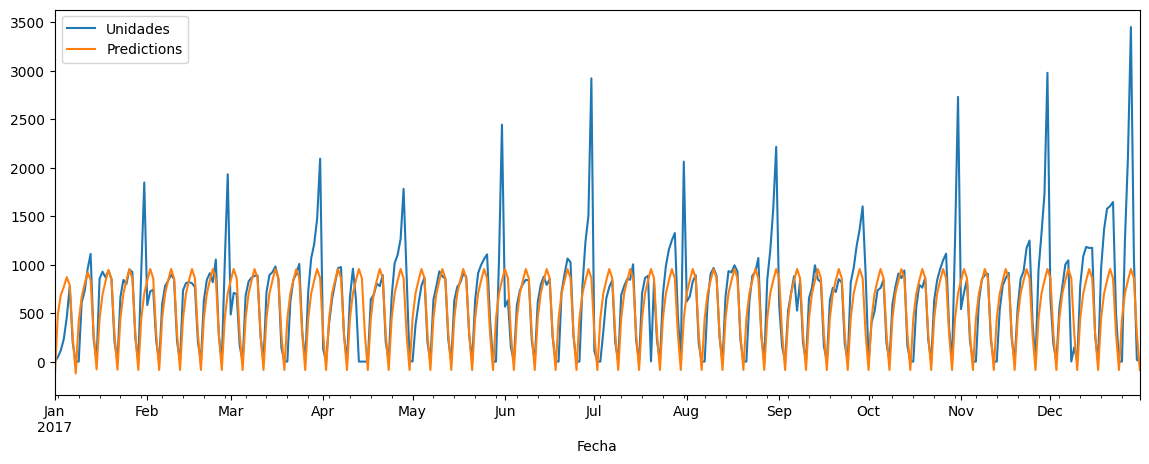

In [ ]:
test.plot(figsize=(14,5))

In [ ]:
# y_pred = regressor.predict(test.index)

print(r2_score(test["Unidades"], true_predictions))

0.4618474501880667


In [ ]:
salida = open("predicciones_2018.txt", "w")
for j in range(0, len(true_predictions)):
    salida.write(str(true_predictions[j]) +"\n")